# Mini neural net training
Authors: Alfredo Canziani, Philipp Schmitt  
Date: 15 Apr, 2020

In [257]:
import torch
from torch import nn, optim
from IPython import display
from PIL import Image, ImageFont, ImageDraw
from matplotlib.pyplot import imshow, axis, figure, subplot, pause
import numpy
import random
import math

%matplotlib inline

In [258]:
# static random seed
torch.manual_seed(0)

In [259]:
# Input definition
class input_settings:
    batch_size = 1
    channels = 1
    height = 8
    width = 8

dummy_X = torch.randn(  # batch of inputs x
    input_settings.batch_size,
    input_settings.channels,
    input_settings.height,
    input_settings.width,
)

In [260]:
# Network architecture
class model_settings:
    conv_channels = 4
    kernel = 3
    pooling_kernel = 3
    flattened = 16
    output_size = 1
    
model = nn.Sequential(
    nn.Conv2d(
        in_channels=input_settings.channels,
        out_channels=model_settings.conv_channels,
        kernel_size=model_settings.kernel,
        bias=True,
    ),
    nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=model_settings.pooling_kernel,
        stride=model_settings.pooling_kernel,
    ),  # we have 4 x 2x2
    nn.Flatten(),  # gives 16
    nn.Linear(
        in_features=model_settings.flattened,
        out_features=model_settings.output_size,
        bias=True,
    ),
)

In [261]:
# Inference
with torch.no_grad():
    print(model(dummy_X).size())

torch.Size([1, 1])


In [262]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [263]:
# Get weights and biases
def get_weights():
    print(
        model[0],
        model[0].weight,
        model[0].bias,
        sep='\n',
    )
    print(
        model[4],
        model[4].weight,
        model[4].bias,
        sep='\n',
    )
    # Maybe add some saving routines

In [264]:
# letter samples
samples = [
    [
        [0,1,1,1],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [0,1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,0,0],
        [1,1,1]
    ],
    [
        [1,1,1,0],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,1,1,0]
    ],
    [
        [1,1,0],
        [1,0,1],
        [1,0,1],
        [1,1,0]
    ]
]

sample_meta = [
    [6,4,'C'],
	[4,3,'C'],
	[6,4,'D'],
	[4,3,'D']
]

(tensor([[[[0., 0., 0., 1., 1., 1., 0., 0.],
           [0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 1., 1., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0.]]]]), tensor(1.))

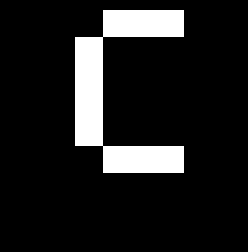

In [265]:
# updated gen. function to match teensy implementation
def generate_data(visualise=False, target=None):
    data = numpy.zeros(shape=(8,8), dtype=numpy.float32)
    
    sample = random.randint(0,len(samples)-1)
    character = sample_meta[sample][2];
    
    x = random.randint(
        0,
        input_settings.width-sample_meta[sample][1]
    )
    y = random.randint(
        0,
        input_settings.height-sample_meta[sample][0]
    )
    
    data[y:y+sample_meta[sample][0],x:x+sample_meta[sample][1]] = samples[sample]
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
        
    return torch.tensor(data).unsqueeze_(0).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)
        
generate_data(visualise=True)

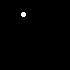

In [266]:
from PIL import Image, ImageDraw
from numpy import interp
from math import cos, sin, radians, pi


def draw_weight(value, size=20):
    rad = interp(value,[-.75,.75],[pi,0])
    im = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(im)
    x, y, r = (
        size/2 + size/3 * cos(rad), 
        size/2 - size/3 * sin(rad),
        4)
    draw.ellipse((x-r/2, y-r/2, x+r/2, y+r/2), fill=(255, 255, 255), outline=None)

    return im

draw_weight(-.25, 70)

In [267]:
# draw weights

def draw_weights(layer, size=20):
    weights = layer.weight.data.clone().numpy()

    n_weights = len(weights[0])
    im = Image.new('RGB', ((size+1)*n_weights, size), (255, 255, 255))

    for i in range(n_weights):
        weight = draw_weight(weights[0][i], size=size)
        im.paste(weight,((size+1)*i,0))

    return im

draw_weights(model[4], size=30)

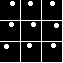

In [268]:
# draw a filter
def draw_filter(filter):
    matrix = Image.new('RGB', (63, 63), (255, 255, 255))
    data = filter.view(3, 3).numpy()
    # go over filter
    # rows
    for x in range(0, data.shape[0]):
        # cols
        for y in range(0, data.shape[1]):
            vis = draw_weight(data[y,x])
            matrix.paste(vis,(x*21,y*21))
    return matrix

filters = model[0].weight.data
draw_filter(filters[0])

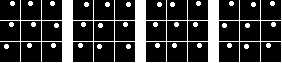

In [269]:
# draw all filters
def draw_filters(layer):
    matrix = Image.new('RGB', (282, 63), (255, 255, 255))
    filters = layer.weight.data.clone()
    for i, filter in enumerate(filters):
        vis = draw_filter(filter)
        matrix.paste(vis, (i*(63+10),0))
    return matrix


draw_filters(model[0])

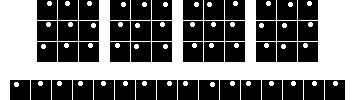

In [270]:
# draw all the weights in the net
def draw_net():
    im = Image.new('RGB', (356, 100), (255, 255, 255))
    im.paste(draw_filters(model[0]), (37,0))
    im.paste(draw_weights(model[4]), (10,80))

    return im

draw_net()

---
# Training

In [271]:
# Set up network training
nb_epochs = 20_000
lr = 1e-3
optimiser = optim.SGD(params=model.parameters(), lr=lr)
#loss = nn.BCEWithLogitsLoss()
loss = nn.BCEWithLogitsLoss()

In [272]:
# Training
for epoch in range(nb_epochs):
    # Training steps
    X, Y = generate_data()
    logits = model(X)  # feed-forward
    
    # not sure if I'm doing this right ...
    logits = logits.squeeze(-2)
    Y = Y.unsqueeze(0)

    J = loss(logits, Y)  # computes the loss
    model.zero_grad()  # cleans up previous gradients
    J.backward()
    optimiser.step()
    
    # Accuracy computation and display
    score, predicted = torch.max(logits, 0)
    acc = (Y == (logits > 0)).sum().float() / len(Y)
    
    if(epoch % 100 == 0):
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, J.item(), acc))
        
        continue
        # skip the code below, used to visualize weight movements on physical net
        
        print(model[0].weight.data)
        
        figure(figsize=(10, 20))
        #visualize_filters(model[0])
        im = draw_net()
        imshow(numpy.asarray(im), aspect='equal', interpolation='nearest')
        
        # im.save('%s.png' % epoch)
        
        #draw_filters(model[0]).save('%i.png' % epoch)
        axis('off');
        pause(0.1)

[EPOCH]: 19900, [LOSS]: 0.279057, [ACCURACY]: 1.000


D


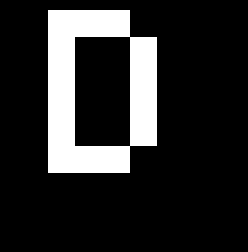

In [277]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=True)[0]) > 0 else 'D')

---
# Visualization & Printing of values

In [278]:
# register hook to get activation after conv layer out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

backward = {}
def get_backward(name):
    def hook(model, input, output):
        backward[name] = {}
        backward[name]['input'] = input
        backward[name]['output'] = output
    return hook

model[0].register_forward_hook(get_activation('conv'))
model[1].register_forward_hook(get_activation('relu'))
model[2].register_forward_hook(get_activation('pool'))
model[3].register_forward_hook(get_activation('flatten'))

model[0].register_backward_hook(get_backward('conv'))
model[1].register_backward_hook(get_backward('relu'))
model[2].register_backward_hook(get_backward('pool'))
model[3].register_backward_hook(get_backward('flatten'))
model[4].register_backward_hook(get_backward('lin'))

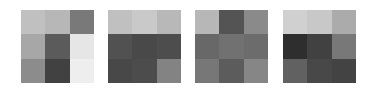

In [279]:
# Visualize weights
def visualize_filters(layer):
    filters = layer.weight.data
    # visualize
    for i in range(0, len(filters)):
        data = filters[i].view(3, 3)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
        
visualize_filters(model[0])

D


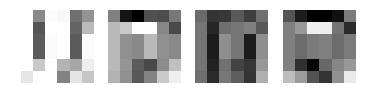

In [286]:
# Inference: C vs. D 
# Conv. activations visualized
with torch.no_grad():
    print('C' if model(generate_data(visualise=False)[0]) > 0 else 'D')
    
    # visualize activations after convolution
    for i, act in enumerate(activation['conv'][0]):
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');

---
# A printout of sample data, activations, outputs to troubleshoot Teensy implementation

In [ ]:
print("CONV WEIGHTS")
print(model[0].weight.clone().detach().squeeze(1).numpy())
print('\nCONV BIAS')
print(model[0].bias.clone().detach().numpy())

print('\nLIN WEIGHTS')
print(model[4].weight.clone().detach().numpy())
print('\nLIN BIAS')
print(model[4].bias.clone().detach().numpy())

---

(tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.]]]]), tensor(1.))


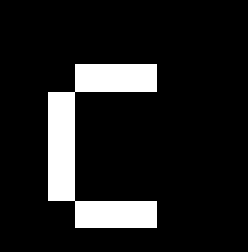

In [55]:
# Generate a sample for all following data dumps
dat = generate_data(visualise=True)
print(dat)

---
## Forward Pass

In [57]:
with torch.no_grad():
    #dat = generate_data(visualise=False)
    x = dat[0]
    y = model(x)
    print('C' if y > 0 else 'D')
    
    print("\n")
    print("CONV:")
    
    # visualize activations after convolution
    for i, act in enumerate(activation['conv'][0]):
        print(act)
    
    print("\n")
    print("RELU:")
    print(activation["relu"])
    print("\n")
    print("POOL:")
    print(activation["pool"])
    print("\n")
    print("FLATTEN:")
    print(activation["flatten"])
    print("\n")
    print("LINEAR:")
    print(y.item())

C


CONV:
tensor([[ 0.9255,  0.4525,  0.5764, -0.2918,  0.1811,  0.0572],
        [ 0.3965,  0.6976,  0.8702,  0.0580,  0.3538,  0.0572],
        [-0.7542,  0.8725,  0.9386,  0.9813,  0.5438,  0.0572],
        [-0.2739,  0.9642,  0.0572,  0.0572,  0.0572,  0.0572],
        [-0.2739,  0.9642,  0.0572,  0.0572,  0.0572,  0.0572],
        [ 1.0673,  1.2357,  0.5764, -0.2918,  0.1811,  0.0572]])
tensor([[ 4.0061e-01,  1.0936e-02, -4.2366e-01, -4.6347e-01, -7.3797e-02,
          3.6079e-01],
        [-4.2153e-01, -8.7835e-01, -8.0255e-01, -4.0990e-01,  2.0031e-03,
          3.6079e-01],
        [-1.3575e-04,  5.7394e-01,  1.8670e+00,  1.4264e+00,  8.6051e-01,
          3.6079e-01],
        [ 1.2510e-01,  6.7130e-02,  3.6079e-01,  3.6079e-01,  3.6079e-01,
          3.6079e-01],
        [ 1.2510e-01,  6.7130e-02,  3.6079e-01,  3.6079e-01,  3.6079e-01,
          3.6079e-01],
        [ 5.5459e-01,  1.5186e-01, -4.2366e-01, -4.6347e-01, -7.3797e-02,
          3.6079e-01]])
tensor([[ 0.0119, -0.2

In [65]:
# Loss
X, Y = dat
logits = model(X)  # feed-forward

# not sure if I'm doing this right ...
logits = logits.squeeze(-2)
Y = Y.unsqueeze(0)

J = loss(logits, Y)  # computes the loss

print('y     ', logits.item())
print('target', Y.item())
print('loss  ', J.item())

y      2.4335522651672363
target 1.0
loss   0.08408807218074799


---
# Framework-less backprop

In [66]:
model.zero_grad()  # cleans up previous gradients
J.backward()

In [67]:
# cache weights + biases BEFORE optimiser step
w_old = {
    'lin': model[4].weight.clone().detach(),
    'lin_bias': model[4].bias.clone().detach(),
    'conv': model[0].weight.clone().detach(),
    'conv_bias': model[0].bias.clone().detach(),
}

In [68]:
def sigmoid(x):
    # e^x => math.e ** 2
    return 1 / (1 + math.e ** -x)

In [69]:
# BCEwithLogits Loss, formula from
# https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Loss.cpp

y = logits

max_val = max(0, -y)
l = (1-Y) * y + max_val + math.log((math.e ** -max_val) + math.e ** (-y-max_val))

# Derivative of BCEwithLogits Loss
# grad_input = (input.sigmoid() - target).mul_(grad);
dl = (sigmoid(y) - Y) * 1

print("L: ", l.item())
print("dL:", dl.item())
print('\nGOAL\n', J.item(), "\n", backward["lin"]["input"][0].item())

L:  0.08408807218074799
dL: -0.080649733543396

GOAL
 0.08408807218074799 
 -0.080649733543396


In [70]:
# backward pass, linear layer
dx = model[4].weight * dl
dw = activation['flatten'] * dl
db = dl

print('\ndW\n',dw)
print(' GOAL\n', model[4].weight.grad)
print(' DIFF', numpy.sum(a=(dw.detach().numpy() - model[4].weight.grad.detach().numpy())))

print('\n\ndX\n',dx)
print(' GOAL\n', backward["lin"]["input"][1])
print(' DIFF', numpy.sum(a=(dx.detach().numpy() - numpy.array(backward["lin"]["input"][1]))))

print('\n\ndB\n',db)
print(' GOAL\n', model[4].bias.grad)
print(' DIFF', numpy.sum(a=(db.detach().numpy() - model[4].bias.grad.detach().numpy())))


dW
 tensor([[-0.0757, -0.0791, -0.0997, -0.0146, -0.1506, -0.1150, -0.0447, -0.0291,
         -0.0118, -0.0319, -0.0088, -0.0000, -0.1411, -0.1129, -0.0163, -0.0163]],
       grad_fn=<MulBackward0>)
 GOAL
 tensor([[-0.0757, -0.0791, -0.0997, -0.0146, -0.1506, -0.1150, -0.0447, -0.0291,
         -0.0118, -0.0319, -0.0088,  0.0000, -0.1411, -0.1129, -0.0163, -0.0163]])
 DIFF 0.0


dX
 tensor([[ 0.0715,  0.0778,  0.0247,  0.0359, -0.0194, -0.0776, -0.0050, -0.0287,
          0.0086, -0.0294, -0.0087,  0.0332, -0.0269, -0.0869, -0.0305, -0.0378]],
       grad_fn=<MulBackward0>)
 GOAL
 tensor([[ 0.0715,  0.0778,  0.0247,  0.0359, -0.0194, -0.0776, -0.0050, -0.0287,
          0.0086, -0.0294, -0.0087,  0.0332, -0.0269, -0.0869, -0.0305, -0.0378]])
 DIFF 0.0


dB
 tensor([-0.0806], grad_fn=<MulBackward0>)
 GOAL
 tensor([-0.0806])
 DIFF 0.0


In [71]:
# backward pass, flatten
out = dx.reshape((4,2,2))
goal = backward['pool']['output']

print(out)
print('\nGOAL\n', goal)

tensor([[[ 0.0715,  0.0778],
         [ 0.0247,  0.0359]],

        [[-0.0194, -0.0776],
         [-0.0050, -0.0287]],

        [[ 0.0086, -0.0294],
         [-0.0087,  0.0332]],

        [[-0.0269, -0.0869],
         [-0.0305, -0.0378]]], grad_fn=<ViewBackward>)

GOAL
 (tensor([[[[ 0.0715,  0.0778],
          [ 0.0247,  0.0359]],

         [[-0.0194, -0.0776],
          [-0.0050, -0.0287]],

         [[ 0.0086, -0.0294],
          [-0.0087,  0.0332]],

         [[-0.0269, -0.0869],
          [-0.0305, -0.0378]]]]),)


In [72]:
# backward pass, maxpool2d
# not implemented here... but it's easy:
# the gradient gets assigned to the item that was max() during forward pass

print('\nGOAL\n', backward['pool']['input'])


GOAL
 (tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0715,  0.0778,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0247,  0.0000,  0.0000,  0.0359,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.0194, -0.0776,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000, -0.0287,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.0050,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0086,  0.0000, -0.0294,  0.0000]

In [73]:
# derivative of relu
# see here: https://towardsdatascience.com/back-propagation-simplified-218430e21ad0

# d = numpy.array(backward['pool']['input'][0][0][0], copy = True)
# d[activation['relu'][0][0] < 0] = 0.

relu_grad = backward['pool']['input'][0][0].clone().detach()

for f in range(0,4):
    for y in range(0,6):
        for x in range(0,6):
            if(activation['act'][0][f][y][x] <= 0):
                relu_grad[f][y][x] = 0
                
print(relu_grad)
print('\nGOAL\n', backward['relu']['input'][0][0])

print('\nDIFF', (backward['relu']['input'][0][0] - relu_grad).sum().item())

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0715,  0.0778,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0247,  0.0000,  0.0000,  0.0359,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0194, -0.0776,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0287,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0050,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0086,  0.0000, -0.0294,  0.0000],
         [ 0.0000, -0

---
## Make an optimiser step

In [74]:
optimiser.step()

In [75]:
# cache weights + biases AFTER optimiser step
w_new = {
    'lin': model[4].weight.clone().detach(),
    'lin_bias': model[4].bias.clone().detach(),
    'conv': model[0].weight.clone().detach(),
    'conv_bias': model[0].bias.clone().detach(),
}

---
## Update weights

In [76]:
# lin layer, weight update
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
weight_update = w_old['lin'].clone()
weight_update -= lr * dw.clone().detach()

# goal
goal = w_new['lin'][0].numpy()
print(weight_update)
print('\nGOAL\n', goal)
print('\nDIFF:', numpy.sum(a=(goal - weight_update[0].numpy())))

tensor([[-0.8860, -0.9646, -0.3057, -0.4446,  0.2404,  0.9619,  0.0626,  0.3562,
         -0.1067,  0.3641,  0.1073, -0.4122,  0.3337,  1.0777,  0.3787,  0.4688]])

GOAL
 [-0.8859708  -0.9646351  -0.30574358 -0.44463044  0.24039814  0.9618884
  0.06261699  0.35623348 -0.10668962  0.36407247  0.10729297 -0.41222888
  0.33366507  1.0777308   0.3787301   0.46880627]

DIFF: 0.0


In [77]:
# lin layer, bias update
new_bias = w_old['lin_bias'].clone() - db * lr

print('CALC:', new_bias.item())
print('GOAL:', model[4].bias.item())
print('DIFF:', (model[4].bias.item()-new_bias).item())

CALC: 0.2839290499687195
GOAL: 0.2839290499687195
DIFF: 0.0


---
#### conv weights

In [81]:
# backward pass, conv

# only doing it here, after optimiser.step() so that model[0].weight.grad has a gradient for comparison

# incoming gradient
g = backward['relu']['input'][0][0]

# gradient var
conv_grad = torch.zeros((4,3,3))

# filters
for f in range(0,4):
    for fy in range(0,3):
        for fx in range(0,3):
            # slide gradient over input X to get dF
            for y in range(0,6):
                for x in range(0,6):
                    conv_grad[f][fy][fx] += g[f][y][x] * dat[0][0][0][y+fy][x+fx]

goal = model[0].weight.grad.clone().squeeze(1)

print(conv_grad.numpy())
print('\nGOAL\n', goal)
print('DIFF', (conv_grad - goal).sum().item())

[[[ 0.17392953  0.14926335  0.07145941]
  [ 0.02466618  0.          0.        ]
  [ 0.0358605   0.02466618  0.02466618]]

 [[-0.09694266 -0.1019891  -0.0193759 ]
  [ 0.         -0.00504644  0.        ]
  [ 0.          0.         -0.00504644]]

 [[-0.02940678  0.00860544  0.00860544]
  [-0.00865244  0.          0.        ]
  [-0.00865244  0.          0.        ]]

 [[-0.11380821 -0.11380821 -0.02689862]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]

GOAL
 tensor([[[ 0.1739,  0.1493,  0.0715],
         [ 0.0247,  0.0000,  0.0000],
         [ 0.0359,  0.0247,  0.0247]],

        [[-0.0969, -0.1020, -0.0194],
         [ 0.0000, -0.0050,  0.0000],
         [ 0.0000,  0.0000, -0.0050]],

        [[-0.0294,  0.0086,  0.0086],
         [-0.0087,  0.0000,  0.0000],
         [-0.0087,  0.0000,  0.0000]],

        [[-0.1138, -0.1138, -0.0269],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])
DIFF 0.0


In [82]:
new_weights = w_old['conv'].clone().squeeze(1)
new_weights -= lr * conv_grad
goal = w_new['conv'].clone().squeeze(1)

print(new_weights)
print('\nGOAL:', goal)
print('DIFF:', (goal - new_weights).sum().item())

tensor([[[ 0.4864,  0.4374, -0.0428],
         [ 0.2965, -0.2957,  0.8122],
         [ 0.1239, -0.4730,  0.8683]],

        [[ 0.4998,  0.5660,  0.4407],
         [-0.3588, -0.4119, -0.3926],
         [-0.4346, -0.3897,  0.0398]],

        [[ 0.4341, -0.3330,  0.0831],
         [-0.1994, -0.1118, -0.1598],
         [-0.0877, -0.2849,  0.0504]],

        [[ 0.6420,  0.5564,  0.3492],
         [-0.6512, -0.4949, -0.0681],
         [-0.2420, -0.4338, -0.4763]]])

GOAL: tensor([[[ 0.4864,  0.4374, -0.0428],
         [ 0.2965, -0.2957,  0.8122],
         [ 0.1239, -0.4730,  0.8683]],

        [[ 0.4998,  0.5660,  0.4407],
         [-0.3588, -0.4119, -0.3926],
         [-0.4346, -0.3897,  0.0398]],

        [[ 0.4341, -0.3330,  0.0831],
         [-0.1994, -0.1118, -0.1598],
         [-0.0877, -0.2849,  0.0504]],

        [[ 0.6420,  0.5564,  0.3492],
         [-0.6512, -0.4949, -0.0681],
         [-0.2420, -0.4338, -0.4763]]])
DIFF: 0.0


In [83]:
# conv layer, bias update
# -> sum of filter gradient is dB
# https://stackoverflow.com/questions/3775032/how-to-update-the-bias-in-neural-network-backpropagation
# https://datascience.stackexchange.com/questions/25081/how-to-update-bias-in-cnn

# biases before weight update
biases = w_old['conv_bias'].clone()

for i in range(len(biases)):
    biases[i] -= g[i].sum() * lr

goal = model[0].bias.clone().detach()

print(biases)
print('GOAL:', goal)
print('DIFF:', (goal - biases).sum().item())

tensor([ 0.0570,  0.3609, -0.0384,  0.2019])
GOAL: tensor([ 0.0570,  0.3609, -0.0384,  0.2019])
DIFF: 0.0


---

## Histogram of trained weights -> needed to calibrate Teensy

In [121]:
import matplotlib.pyplot as plt

In [250]:
c_weights = model[0].weight.clone().detach().numpy().flatten()
l_weights = model[4].weight.clone().detach().numpy().flatten()

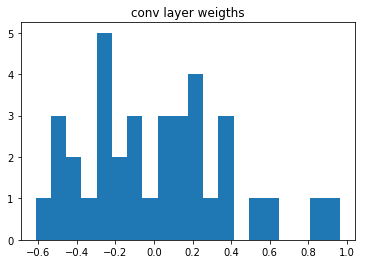

In [251]:
a = numpy.hstack(c_weights)
_ = plt.hist(a, bins=20)  # arguments are passed to np.histogram
plt.title("conv layer weigths")

plt.show()

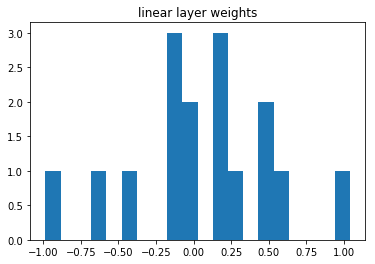

In [252]:
a = numpy.hstack(l_weights)
_ = plt.hist(a, bins=20)  # arguments are passed to np.histogram
plt.title("linear layer weights")

plt.show()

In [302]:
at = activation['flatten'][0].numpy().flatten()
print(at)

[1.7113621  2.652094   1.6652656  1.6652656  1.0914052  1.09125
 0.45121658 0.87274873 0.12399553 0.12399553 0.12399553 0.377969
 0.867496   0.86399525 0.47998905 0.8315278 ]


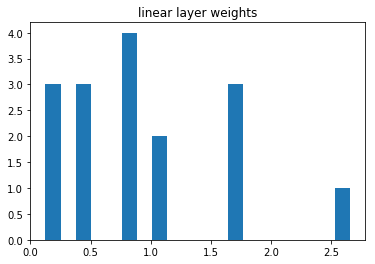

In [303]:
a = numpy.hstack(l_weights)
_ = plt.hist(at, bins=20)  # arguments are passed to np.histogram
plt.title("linear layer weights")

plt.show()